In [168]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import cftime
from glob import glob
import cmocean

nitrogen_molar_weight = 14
seconds_per_year = 24*60*60*365

## Generate paths

In [169]:
# pp path
pp_path = '/archive/jyl/fre/ESM45/ESM45_COBALTv3_20250224/ESM4.5v02cobv3_piC/gfdl.ncrc5-intel23-prod-openmp/pp/'
#pp_path = '/archive/jyl/fre/OM4_05/pull_requests/2025_02/OM4_05_COBALTv3_jra55_const/gfdl.ncrc5-intel23-prod/pp/'

In [170]:
grid_file = pp_path + 'ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

In [171]:
# nitrogen vertical integral 
diag_type = 'ocean_cobalt_tracers_instant'
variable = 'wc_vert_int_n'

total_vertint_files = glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + variable + '.nc')
#print(total_vertint_files)

In [172]:
# nitrogen budget files
# nitrogen cycle fluxes
diag_type = 'ocean_cobalt_fluxes_int'
variables = ['wc_vert_int_nfix','wc_vert_int_jno3denit','wc_vert_int_jnamx','wc_vert_int_jno3_iceberg']

flux_vertint_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
flux_vertint_files = sorted([f for fi in flux_vertint_files for f in fi]) # nested list comprehension

In [173]:
# nitrogen budget files
# surface fluxes
diag_type = 'ocean_cobalt_sfc'
variables = ['nh4_stf_gas','runoff_flux_no3','runoff_flux_ldon','runoff_flux_sldon','runoff_flux_srdon','runoff_flux_ndet',\
             'dep_dry_nh4','dep_wet_nh4','dep_dry_no3','dep_wet_no3']

surf_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
surf_files = sorted([f for fi in surf_files for f in fi]) # nested list comprehension
#print(surf_files)

In [174]:
# nitrogen budget files
# bottom fluxes
diag_type = 'ocean_cobalt_btm'
variables = ['fno3denit_sed','fn_burial']

btm_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
btm_files = sorted([f for fi in btm_files for f in fi]) # nested list comprehension

## Read in files

In [175]:
total = xr.open_mfdataset(total_vertint_files, combine='by_coords')

In [176]:
flux = xr.open_mfdataset(flux_vertint_files, combine='by_coords')

In [177]:
surf = xr.open_mfdataset(surf_files, combine='by_coords')

In [178]:
btm = xr.open_mfdataset(btm_files, combine='by_coords')

## Compute Global Inventory

These values are from ocean_cobalt_tracer_instant and are written out at the end of the year

In [179]:
global_total = (total.wc_vert_int_n * grid.areacello).sum(dim=['xh','yh']) * nitrogen_molar_weight
global_total = global_total

Text(0.5, 1.0, 'Global nitrogen inventory (Pg)')

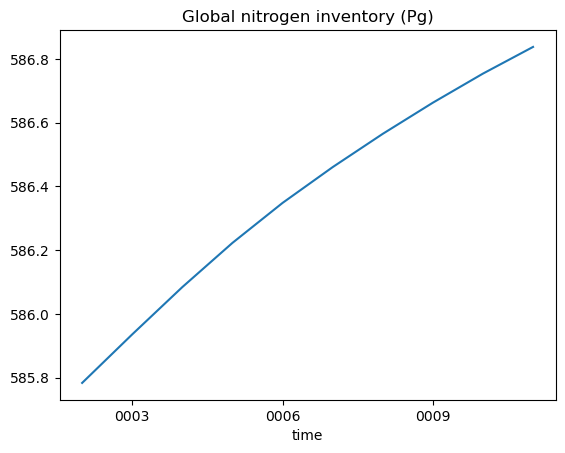

In [180]:
(global_total/1e15).plot()
#plt.ylim(37.94,37.948)
plt.title('Global nitrogen inventory (Pg)')

## Compute Fluxes

In [181]:
total_runoff = surf.runoff_flux_no3 + surf.runoff_flux_ldon + surf.runoff_flux_sldon + \
               surf.runoff_flux_srdon + surf.runoff_flux_ndet

total_runoff = (total_runoff * grid.areacello).sum(dim=['xh','yh'])
total_runoff = total_runoff * nitrogen_molar_weight * seconds_per_year

In [182]:
total_deposition = surf.dep_dry_nh4 + surf.dep_wet_nh4 + \
               surf.dep_dry_no3 + surf.dep_wet_no3 + \
               surf.nh4_stf_gas

total_deposition = (total_deposition * grid.areacello).sum(dim=['xh','yh'])
total_deposition = total_deposition * nitrogen_molar_weight * seconds_per_year

In [183]:
iceberg = (flux.wc_vert_int_jno3_iceberg * grid.areacello).sum(dim=['xh','yh']) 
iceberg = iceberg * nitrogen_molar_weight * seconds_per_year

In [184]:
nfix = (flux.wc_vert_int_nfix * grid.areacello).sum(dim=['xh','yh']) 
nfix = nfix * nitrogen_molar_weight * seconds_per_year

In [185]:
denit_amx = flux.wc_vert_int_jno3denit + flux.wc_vert_int_jnamx + btm.fno3denit_sed

denit_amx = (denit_amx * grid.areacello).sum(dim=['xh','yh'])
denit_amx = denit_amx * nitrogen_molar_weight * seconds_per_year

In [186]:
burial = (btm.fn_burial * grid.areacello).sum(dim=['xh','yh'])
burial = burial * nitrogen_molar_weight * seconds_per_year

Text(0.5, 1.0, 'Net nitrogen fluxes (grams)')

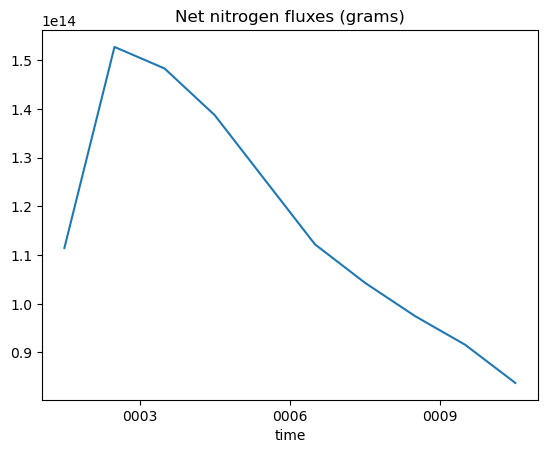

In [187]:
net_flux = nfix + total_runoff + total_deposition + iceberg - denit_amx - burial
net_flux.plot()
plt.title('Net nitrogen fluxes (grams)')

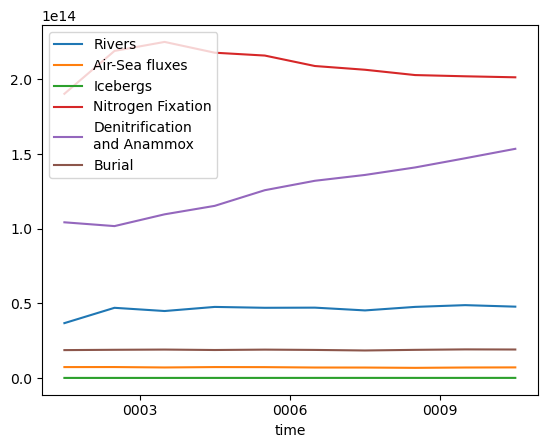

In [188]:
total_runoff.plot()
total_deposition.plot()
iceberg.plot()
nfix.plot()
denit_amx.plot()
burial.plot()
plt.legend(['Rivers','Air-Sea fluxes','Icebergs','Nitrogen Fixation','Denitrification\nand Anammox','Burial'])

## Close budgets
The total carbon inventory should be equal to the starting inventory plus the carbon fluxes
In this case we start with year 2 and onwards, because the wc_vert_int_c term is saved at the end of year 1

Text(0.5, 1.0, 'Nitrogen fluxes as calculated by the change in the global N inventory')

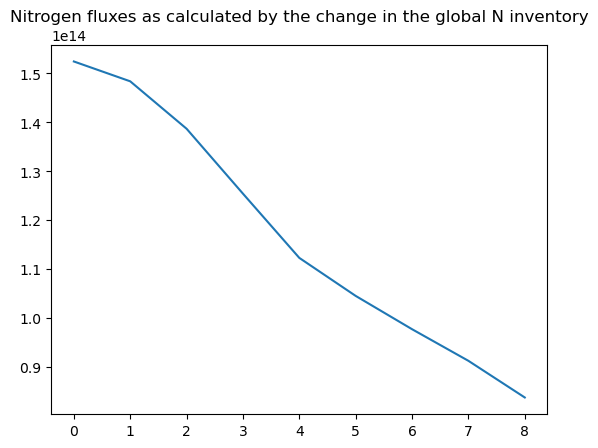

In [189]:
plt.plot(np.diff(global_total))
plt.title('Nitrogen fluxes as calculated by the change in the global N inventory')

In [190]:
np.diff(global_total.values)

array([1.52419799e+14, 1.48365350e+14, 1.38675904e+14, 1.25413045e+14,
       1.12287625e+14, 1.04522324e+14, 9.77190959e+13, 9.12594651e+13,
       8.37690421e+13], dtype=float32)

In [191]:
net_flux.values[1:]

array([1.52776856e+14, 1.48344390e+14, 1.38761851e+14, 1.25489190e+14,
       1.12227385e+14, 1.04310390e+14, 9.74683599e+13, 9.15782749e+13,
       8.37428687e+13])

Text(0.5, 1.0, 'Global nitrogen inventory (Pg)')

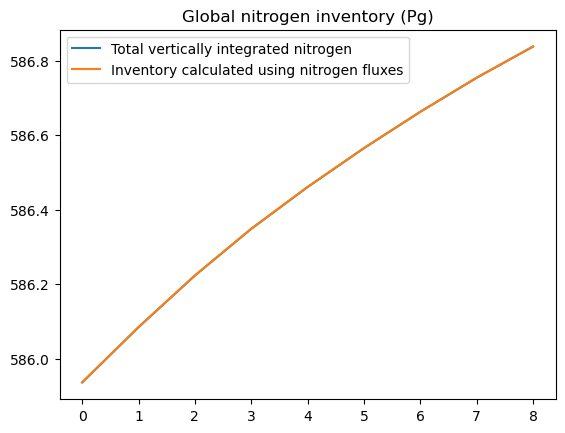

In [192]:
plt.plot(global_total.values[1:]/1e15)
plt.plot((np.cumsum(net_flux.values[1:])+global_total.values[0])/1e15)
plt.legend(['Total vertically integrated nitrogen','Inventory calculated using nitrogen fluxes'])
plt.title('Global nitrogen inventory (Pg)')

Text(0.5, 1.0, 'Total global nitrogen inventory imbalance')

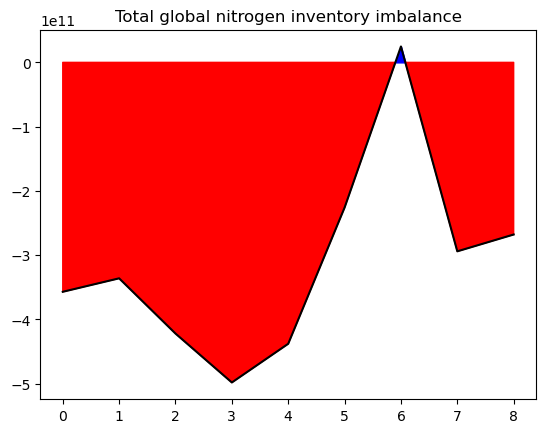

In [193]:
fig,ax = plt.subplots(1,1)
imbalance=(global_total.values[1:] - (np.cumsum(net_flux.values[1:])+global_total.values[0]))
plt.plot(imbalance, color='black')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance>0, interpolate=True, color='blue')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance<0, interpolate=True, color='red')
plt.title('Total global nitrogen inventory imbalance')

Text(0.5, 1.0, 'Total global nitrogen budget imbalance')

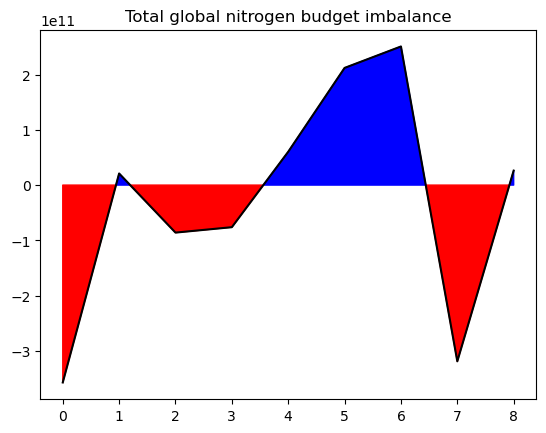

In [194]:
fig,ax = plt.subplots(1,1)
imbalance=(np.diff(global_total.values) - net_flux.values[1:])
plt.plot(imbalance, color='black')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance>0, interpolate=True, color='blue')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance<0, interpolate=True, color='red')
plt.title('Total global nitrogen budget imbalance')